# Day 3 & 4 Practical: Applied Linear Algebra with NumPy
**Objective:** Bridge theoretical linear algebra concepts (Gaussian elimination, Cramer's Rule, SVD) with practical, applied implementations in Python using NumPy.

In [1]:
## Setup

# Run this cell to import the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import resize
import time
import sympy # We'll use this for a textbook RREF check

# Set a consistent random seed for reproducible results
np.random.seed(42)

---
## Day 3: The Matrix Toolkit & Solving Systems
**Goal:** Master NumPy's core matrix operations and implement classic algorithms for solving $Ax=b$.

### Part 1: NumPy Warm-up (The Toolkit)

**Task:** Get comfortable creating and manipulating NumPy arrays.

In [ ]:
# 1. Create a 3x3 matrix 'A' with random integers between 0-9
A = np.random.randint(0, 10, (3, 3))
print("Matrix A:\n", A)

# 2. Create a 3-element vector 'b' with random integers
b = np.random.randint(0, 10, 3)
print("\nVector b:\n", b)

# 3. Create a 3x3 identity matrix 'I'
I = np.array([[1,0,0],[0,1,0],[0,0,1]])
#I=np.eye(3)
print("\nIdentity Matrix I:\n", I)

# 4. Select and print the *second column* of A
col_2 = I[:,1]
print("\nSecond Column of A:\n", col_2)

# 5. Select and print the 2x2 sub-matrix from the top-left of A
top_left_2x2 = I[:2,:2]
print("\nTop-left 2x2 of A:\n", top_left_2x2)

# 6. Compute the matrix-vector product of A and b. (Ensure b is a 1D vector)
Ab = A@b
print("\nMatrix-vector product A @ b:\n", Ab)

# 7. Compute the matrix-matrix product of A and I.
AI = A@I
print("\nMatrix-matrix product A @ I:\n", AI)

Matrix A:
 [[2 2 3]
 [7 5 7]
 [0 7 3]]

Vector b:
 [0 7 3]

Identity Matrix I:
 [[1 0 0]
 [0 1 0]
 [0 0 1]]

Second Column of A:
 [0 1 0]

Top-left 2x2 of A:
 [[1 0]
 [0 1]]

Matrix-vector product A @ b:
 [23 56 58]

Matrix-matrix product A @ I:
 [[2 2 3]
 [7 5 7]
 [0 7 3]]


: 

---
### Part 2: Solving $Ax=b$ (The "Right" Way vs. The "Classic" Way)

**Goal:** Compare the fast, built-in NumPy solver with the "textbook" Cramer's Rule.

In [ ]:
# Let's define a new, guaranteed-invertible system
A = np.array([[2, 1, -1],
              [-3, -1, 2],
              [-2, 1, 2]], dtype=float)

b = np.array([8, -11, -3], dtype=float)

Ai = A
Ai[:,2]=b
print(Ai)

[[  2.   1.   8.]
 [ -3.  -1. -11.]
 [ -2.   1.  -3.]]


**Method 1 (The "Real World" Answer): `np.linalg.solve()`**

This is the fast, stable, and standard method.

In [42]:
# 1. Use np.linalg.solve to find x
start_time = time.time()
x_solve = np.linalg.solve(A,b)
print(f"--- np.linalg.solve ---")
print(f"Solution x: {x_solve}")
print(f"Time: {time.time() - start_time:.8f} seconds")

# 2. Verify your answer by computing A @ x
verification = A @ x_solve
print(f"Verification (A @ x): {verification}")
print(f"Original b: {b}")
print(f"Match: {np.allclose(verification, b)}") # np.allclose checks for float equality

--- np.linalg.solve ---
Solution x: [-0.  0.  1.]
Time: 0.00367045 seconds
Verification (A @ x): [  8. -11.  -3.]
Original b: [  8. -11.  -3.]
Match: True


**Method 2 (Cramer's Rule): $x_i = \det(A_i) / \det(A)$**

**Task:** Implement Cramer's rule from scratch. This is a *much* harder coding task.

In [43]:
def solve_cramers_rule(A, b):
    """
    Solves Ax=b using Cramer's Rule.
    Returns the solution vector x.
    """
    n = A.shape[0]

    if n!=b.shape[0]:
        return None

    solution = np.zeros(n)
    
    # 1. Calculate the determinant of the main matrix A
    det_A = np.linalg.det(A)
    
    # 2. Add a check: if det_A is very close to zero, the matrix is
    # non-invertible. Return None (or raise an error).
    if np.isclose(det_A, 0):
        print("Error: Matrix is singular, Cramer's rule cannot be applied.")
        return None
        
    # 3. Loop i from 0 to n-1 (for x_0, x_1, ...)
    for i in range(n):
        
        # 4. Create a *copy* of A. This is critical.
        Ai = A.copy()
        
        # 5. Replace the i-th column of the copy (Ai) with the vector b
        Ai[:,i]=b
        
        # 6. Calculate the determinant of this new matrix Ai
        det_Ai = np.linalg.det(Ai)
        
        # 7. Calculate and store the i-th element of the solution
        solution[i] = det_Ai/det_A
        
    return solution

# --- Test Your Function ---
start_time = time.time()
x_cramer = solve_cramers_rule(A, b)
print(f"\n--- Cramer's Rule ---")
print(f"Solution x: {x_cramer}")
print(f"Time: {time.time() - start_time:.8f} seconds")

# 3. Verification
if x_cramer is not None:
    print(f"Match np.linalg.solve: {np.allclose(x_solve, x_cramer)}")


--- Cramer's Rule ---
Solution x: [ 2.44249065e-15 -7.12393107e-16  1.00000000e+00]
Time: 0.01287985 seconds
Match np.linalg.solve: True


### Part 3: Gaussian Elimination
**Goal:** Implement the "guts" of a solver. We'll implement **Forward Elimination** to get an upper-triangular matrix.

In [ ]:
import numpy as np

def Gauss_Jordan_elimination(A_in, b_in):
    """
    Solves the linear system Ax=b using full Gauss-Jordan elimination.

    This function performs two main phases:
    1.  Forward Elimination: Transforms the augmented matrix [A|b] into
        an upper-triangular form.
    2.  Backward Elimination: Continues to reduce the matrix to
        Reduced Row Echelon Form (RREF), which is [I|x].

    The function finally returns the RREF matrix, where the last column
    is the solution vector 'x'.
    """
    
    # --- Setup ---
    # 1. Create safe copies of the input arrays
    A = A_in.copy()
    b = b_in.copy().reshape(-1, 1) # Ensure b is a column vector
    
    # 2. Create the augmented matrix [A|b]
    # Note: Using the copies 'A' and 'b' is crucial
    aug_matrix = np.hstack([A, b])
    print("Original Augmented Matrix:\n", aug_matrix)
    
    n = aug_matrix.shape[0] # Number of rows (and columns in A)
    
    # --- Part 1: Forward Elimination ---
    # Goal: Create zeros *below* each pivot.
    
    # Loop through each row 'i' (which is the pivot row)
    for i in range(n):
        
        # (Pivoting code would go here to handle zero pivots)
        
        # Get the pivot element (A[i, i])
        pivot_val = aug_matrix[i, i]
        
        # Loop through all rows 'j' *below* the pivot row
        for j in range(i + 1, n):
            
            # Calculate the multiplier 'm'
            m = aug_matrix[j, i] / pivot_val
            
            # Update the entire row 'j' to create a zero at [j, i]
            aug_matrix[j, :] = aug_matrix[j, :] - m * aug_matrix[i, :]

    print("\nUpper-Triangular Matrix:\n", aug_matrix)

    # --- Part 2: Backward Elimination ---
    # Goal: Create zeros *above* each pivot.
    
    # Loop *backwards* from the last pivot row (n-1) up to the first (0)
    for i in range(n - 1, -1, -1):

        # Get the pivot element
        pivot_val = aug_matrix[i, i] 

        # Loop *backwards* through all rows 'j' *above* the pivot row
        for j in range(i - 1, -1, -1):

            # Calculate the multiplier 's'
            s = aug_matrix[j, i] / pivot_val

            # Update the entire row 'j' to create a zero at [j, i]
            aug_matrix[j, :] = aug_matrix[j, :] - s * aug_matrix[i, :]
        
        # --- Part 3: Normalization ---
        # Goal: Make the pivot element A[i, i] equal to 1.
        # We do this after using row 'i' to eliminate elements above.
        aug_matrix[i, :] = aug_matrix[i, :] / pivot_val

    print("\nRow Reduced Echelon Form (RREF) [I|x]:\n", aug_matrix)
    return aug_matrix

# --- Test Your Function ---
A = np.array([[2, 1, -1],
              [-3, -1, 2],
              [-2, 1, 2]], dtype=float)

b = np.array([8, -11, -3], dtype=float)

solution_matrix = Gauss_Jordan_elimination(A, b)

# The solution is the last column
x_solution = solution_matrix[:, -1]
print(f"\nSolution vector x: {x_solution}")

Original Augmented Matrix:
 [[  2.   1.  -1.   8.]
 [ -3.  -1.   2. -11.]
 [ -2.   1.   2.  -3.]]

Upper-Triangular Matrix:
 [[ 2.   1.  -1.   8. ]
 [ 0.   0.5  0.5  1. ]
 [ 0.   0.  -1.   1. ]]

Row Reduced Echelon Form (RREF) [I|x]:
 [[ 1.  0.  0.  2.]
 [ 0.  1.  0.  3.]
 [-0. -0.  1. -1.]]

Solution vector x: [ 2.  3. -1.]


**Final Check: `sympy` RREF**

Let's use the symbolic math library `sympy` to see the "textbook" Reduced Row Echelon Form (RREF).

In [65]:
# 1. Create the augmented matrix in sympy
sympy_aug = sympy.Matrix(np.hstack([A, b.reshape(-1, 1)]))

# 2. Call the .rref() method
# rref() returns two things: the RREF matrix and the pivot columns
rref_matrix, pivot_cols = sympy_aug.rref()

print("--- SymPy RREF ---")
print("RREF Matrix:\n", rref_matrix)
print("Pivot Columns:", pivot_cols)
# The solution 'x' is the last column of the RREF matrix!

--- SymPy RREF ---
RREF Matrix:
 Matrix([[1, 0, 0, 2.00000000000000], [0, 1, 0, 3.00000000000000], [0, 0, 1, -1.00000000000000]])
Pivot Columns: (0, 1, 2)


## Day 4: Linear Algebra for Data & Images

**Goal:** Understand matrix decomposition (Eigen, SVD) and its application in data science.

### Part 1: Eigen-decomposition ($A = V \Lambda V^{-1}$)
**Concept:** $Av = \lambda v$. Eigenvectors ($v$) are the "axes" of a matrix's transformation. This is the math behind PCA.

In [ ]:
# 1. Create a 2x2 symmetric matrix
S = np.array([[5, 2],
              [2, 2]], dtype=float)

# 2. Use np.linalg.eig() to get eigenvalues and eigenvectors
eig_vals, eig_vecs = np.linalg.eig(S)

print("Eigenvalues (Lambda):\n", eig_vals)
print("\nEigenvectors (V):\n", eig_vecs)

# 3. Verify the eigenvector definition: A @ v = lambda * v
# Select the first eigenvector and eigenvalue
v1 = eig_vecs[:, 0]
lambda1 = eig_vals[0]
lhs =  S @ v1 
rhs = lambda1*v1 

print(f"\nVerification (A @ v1 = lambda1 * v1)")
print(f"A @ v1 = {lhs}")
print(f"lambda1 * v1 = {rhs}")
print(f"Match: {np.allclose(lhs, rhs)}")


# 4. Reconstruct A from its parts: A = V @ Lambda @ V_inv
Lambda2 = np.diag(eig_vals)
V_inv = np.linalg.inv(eig_vecs)
A_reconstructed = eig_vecs @ Lambda2 @ V_inv


print("\n--- Reconstruction ---")
print("Original A:\n", S)
print("Reconstructed A:\n", A_reconstructed)
print(f"Match: {np.allclose(S, A_reconstructed)}")

Eigenvalues (Lambda):
 [6. 1.]

Eigenvectors (V):
 [[ 0.89442719 -0.4472136 ]
 [ 0.4472136   0.89442719]]

Verification (A @ v1 = lambda1 * v1)
A @ v1 = [5.36656315 2.68328157]
lambda1 * v1 = [5.36656315 2.68328157]
Match: True
[[6. 0.]
 [0. 1.]]
[[ 0.89442719 -0.4472136 ]
 [ 0.4472136   0.89442719]]

--- Reconstruction ---
Original A:
 [[5. 2.]
 [2. 2.]]
Reconstructed A:
 [[5. 2.]
 [2. 2.]]
Match: True


### Part 2: Singular Value Decomposition (SVD) ($A = U \Sigma V^T$)

**Concept:** SVD is the most powerful and general decomposition. It works on *any* $m \times n$ matrix.

In [86]:
# 1. Create a non-square 3x2 matrix
M = np.array([[1, 2],
              [3, 4],
              [5, 6]], dtype=float)

# 2. Use np.linalg.svd()
# We use full_matrices=False to get the "economy" SVD,
# which is more useful for reconstruction.
U, s, V_T = np.linalg.svd(M, full_matrices=False)

print("U (Left Singular Vectors):\n", U)
print("\ns (Singular Values, 1D vector):\n", s)
print("\nV_T (Right Singular Vectors, Transposed):\n", V_T)

# 3. Reconstruct M from its parts: M = U @ Sigma @ V_T*

# First, we must convert the 1D vector 's' into a 2D diagonal
# matrix 'Sigma'. 
# With full_matrices=False, Sigma is just the square (k x k) matrix.

Sigma = np.diag(s) 

print("\nSigma (2D Matrix):\n", Sigma)

# Now, compute the full reconstruction
M_reconstructed = U @ Sigma @ V_T

print("\n--- Reconstruction ---")
print("Original M:\n", M)
print("Reconstructed M:\n", M_reconstructed)
print(f"Match: {np.allclose(M, M_reconstructed)}")

U (Left Singular Vectors):
 [[-0.2298477   0.88346102]
 [-0.52474482  0.24078249]
 [-0.81964194 -0.40189603]]

s (Singular Values, 1D vector):
 [9.52551809 0.51430058]

V_T (Right Singular Vectors, Transposed):
 [[-0.61962948 -0.78489445]
 [-0.78489445  0.61962948]]

Sigma (2D Matrix):
 [[9.52551809 0.        ]
 [0.         0.51430058]]

--- Reconstruction ---
Original M:
 [[1. 2.]
 [3. 4.]
 [5. 6.]]
Reconstructed M:
 [[1. 2.]
 [3. 4.]
 [5. 6.]]
Match: True


### Challenge: Image Compression with SVD
**Goal:** Use SVD to perform a "low-rank approximation" of a real image. This is the core of PCA and many compression techniques.

Loading and preparing image...


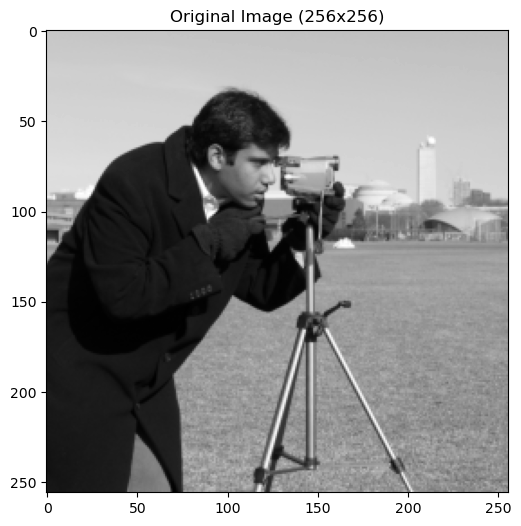

Performing SVD...
SVD Complete.


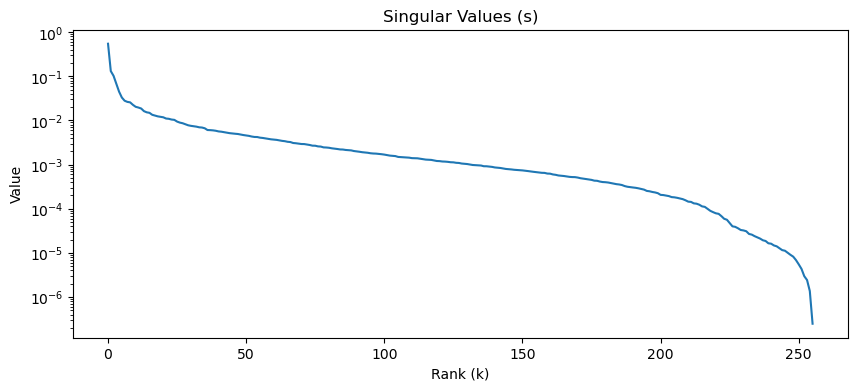

Notice how fast the values drop!


In [91]:
# 1. Load the image, convert to grayscale (float), and resize
print("Loading and preparing image...")
img = data.camera()
img = resize(img, (256, 256)) # Resize to 256x256
img = img.astype(float) / 255.0 # Normalize to [0, 1]

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title("Original Image (256x256)")
plt.show()

# 2. Perform SVD on the 2D image matrix
print("Performing SVD...")
U, s, V_T = np.linalg.svd(img, full_matrices=True)
print("SVD Complete.")

# 3. Plot the singular values 's'
plt.figure(figsize=(10, 4))
plt.plot(s)
plt.title("Singular Values (s)")
plt.xlabel("Rank (k)")
plt.ylabel("Value")
plt.semilogy() # Use a log-scale for the y-axis
plt.show()
print("Notice how fast the values drop!")

**Your Task: Write the Reconstruction Function**

Write a function that reconstructs the image using only the **top `k` singular values**.

The formula is: $A_k = U_k \cdot \Sigma_k \cdot (V_T)_k$
 * $U_k$ is the first $k$ columns of $U$.
 * $\Sigma_k$ is a $k \times k$ diagonal matrix of the first $k$ singular values.
 * $(V_T)_k$ is the first $k$ rows of $V_T$.

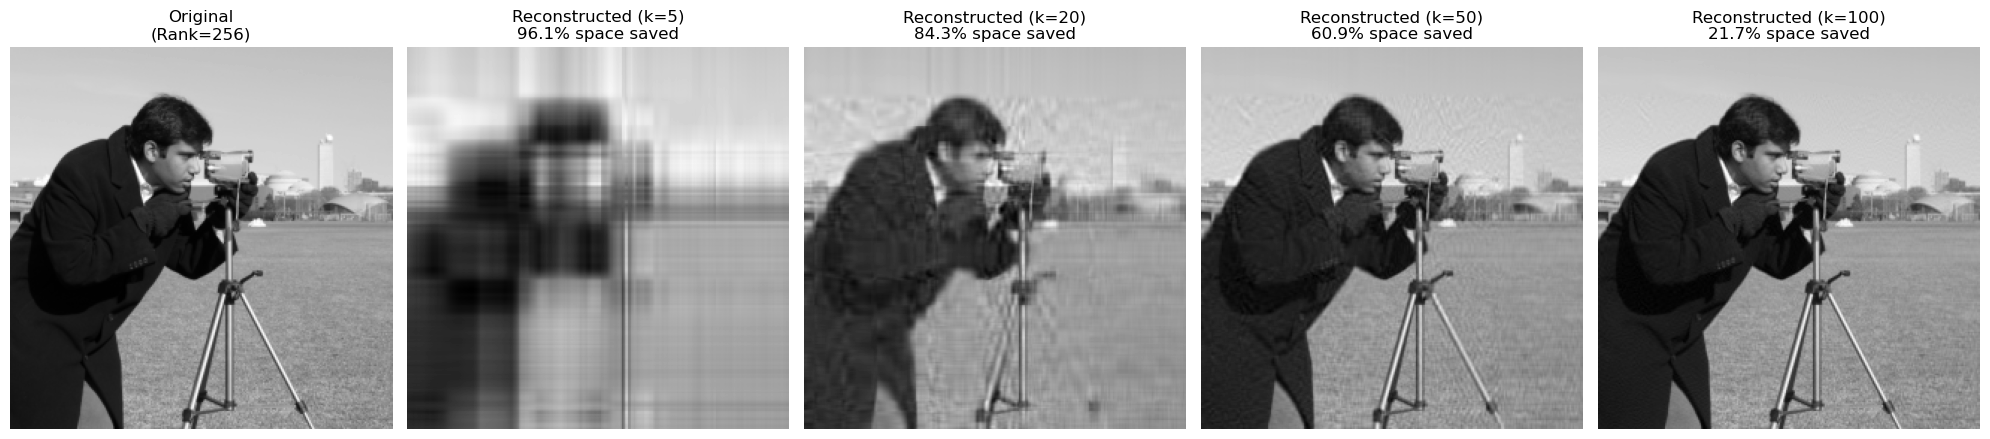

In [94]:
def reconstruct_image(U, s, V_T, k):
    """
    Reconstructs an image from its SVD components using only the top 'k' singular values.
    """
    # 1. Select the first k columns of U
    U_k = U[:,0:k-1]
    
    # 2. Select the first k singular values and make a k x k diagonal matrix
    # YOUR CODE HERE
    Sigma_k = np.diag(s[0:k-1])
    
    # 3. Select the first k rows of V_T
    # YOUR CODE HERE
    V_T_k = V_T[0:k-1,:]
    
    # 4. Compute the reconstructed image by multiplying the components
    # YOUR CODE HERE
    img_reconstructed = U_k @ Sigma_k @ V_T_k
    
    return img_reconstructed

# --- Test your function ---

# 5. Choose your 'k' values to test
k_values = [5, 20, 50, 100]

fig, axes = plt.subplots(1, len(k_values) + 1, figsize=(20, 5))

# Plot original
axes[0].imshow(img, cmap='gray')
axes[0].set_title(f"Original\n(Rank={img.shape[0]})")
axes[0].axis('off')

# Plot reconstructions
for i, k in enumerate(k_values):
    
    # Call your function
    reconstructed = reconstruct_image(U, s, V_T, k)
    
    # Calculate storage size
    original_size = img.size
    # U_k + s_k + V_T_k
    compressed_size = U[:, :k].size + s[:k].size + V_T[:k, :].size
    compression_ratio = 100 * (1 - (compressed_size / original_size))
    
    axes[i+1].imshow(reconstructed, cmap='gray')
    axes[i+1].set_title(f"Reconstructed (k={k})\n{compression_ratio:.1f}% space saved")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

**Analysis:**

The image quality increases as the rank k increases. 

This SVD analysis shows that most of the information is contained in the highest singular values. 

Indeed, the compressed picture with k = 100 is highly similar to the original full-rank picture. 